In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

import vaex
import os

from cycler import cycler

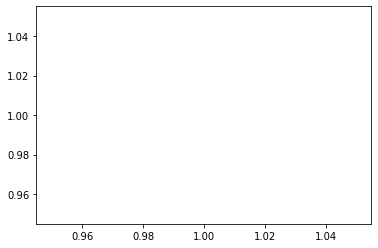

In [2]:


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.rcParams["axes.prop_cycle"] = cycler("color",('indigo','b','r','k','#ff7f0e','g'))
plt.show()

In [3]:
path = "/net/virgo01/data/users/spirov/Nexus Project/torchData"
p2 = "/net/virgo01/data/users/spirov/Nexus Project/"

In [4]:
@vaex.register_function()
def correct(x):
    L = 75000
    return np.where(np.abs(x)>L/2, x-np.sign(x)*L,x)

def localizeDataFrame(absDf, x,y,z):
    rx = absDf.X - x
    ry = absDf.Y - y
    rz = absDf.Z - z
    
    L = 75000
    
    relx = rx.correct()
    rely = ry.correct()
    relz = rz.correct()
    
    
    relR = np.sqrt(relx**2 + rely**2+relz**2)
    
    theta = np.arccos(-relz/relR)
    fi = np.arctan2(relx,rely)
    
    relDf = absDf.copy()
    
    Vaway = (relx*absDf.Vx+rely*absDf.Vy+relz*absDf.Vz)/relR
    
        
    relDf["Th"] = theta
    relDf["Fi"] = fi
    relDf["R"] = relR
    relDf["CZ"] = relR/10 +Vaway
    
    
    return relDf


    
c = 75000/2
df = vaex.open(p2+"baby_135.hdf5")

cdf = localizeDataFrame(df,c,c,c)

In [5]:
name = "testMan.hdf5"
cdf.export_hdf5(path+"/relativeDataFrames/"+name)

In [8]:
class CustomVaexDataset(Dataset):
    def __init__(self,frameDir):
        self.lengt = len(os.listdir(frameDir))
        self.frameDir = frameDir
    
    def __len__(self):
        return self.lengt
        
        
    def __getitem__(self,idx):
        fil = self.frameDir+os.listdir(self.frameDir)[idx]
        df = vaex.open(fil)
        
        th = df.Th.values
        fi = df.Fi.values
        R = df.R.values
        CZ = df.CZ.values
        
        broken = np.array((CZ,th,fi))
        truth = np.array((R,th,fi))
        
        return torch.tensor(broken), torch.tensor(truth)
                 
                 
                 

In [9]:
ds = CustomVaexDataset(path+"/relativeDataFrames/")

In [10]:
a,b = ds.__getitem__(0)

In [11]:
a.size()

torch.Size([3, 94197])

In [12]:
a.flatten()

tensor([4.2277e+03, 4.2104e+03, 4.1572e+03,  ..., 1.0839e+00, 2.0415e+00,
        1.0825e+00], dtype=torch.float64)

In [13]:
type(ds)

__main__.CustomVaexDataset

# Goals:



> create dataset of some size

> construct model with appropriate architecture